In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import ml_insights as mli
%matplotlib inline
sns.set_style('whitegrid')

# Questions

Thumbtack has decided to take a closer look at performance in two of its largest categories - House
Cleaning and Local Moving. Please complete the analyses suggested below and overlay your own
recommendations for how we can improve and grow our marketplace. In your analysis, please also note
any steps you took to transform or clean the data.



(2) Quotes​ ​Per​ ​Request
* What is the distribution of number of quotes per request?
* What factors contribute to some requests getting more quotes than others?

(3) Job​ ​Value
* By category, what is the distribution of quote prices for a project?
* By category, what price do you think Thumbtack should charge pros to quote? Why?
Explain your reasoning for any assumptions that you make.

(4) Further​ ​Exploration
* Briefly describe two other questions or analyses you would be interested in pursuing if
you had more time to explore this data

We encourage you to explain and hypothesize about the drivers behind your findings, and to make
business recommendations based on your results. We also value brevity - only include the analysis &
charts that you believe are most relevant to your answers

## Reading the data

#### Visitors

This dataset contains a list of unique Thumbtack visitors who started request forms in either house
cleaning or local moving categories within the last few months. Some of these users submitted a
request. These customers then received between 0 and 5 quotes from pros (i.e., professionals providing
services on Thumbtack). Customers who received quotes then had the option to hire one of the pros.
date (string) the day the visitor came to Thumbtack

- device (string): whether the visitor is using a desktop or mobile device
- category (string): category for which the visitor needs a project done
- request_sent (integer): 1 if the user sent a request, 0 if not
- request_id (integer): unique identifier for a request, NA if the user did not submit a request
- how_far (string): for requests in the moving category, how far the customer estimates that they will move
- num_rooms (string): for requests in the cleaning category, how many rooms the customer has
- num_baths (string): for requests in the cleaning category, how many bathrooms the customer has

In [2]:
visitors = pd.read_csv('thumbtack/visitors.csv')

In [3]:
visitors.head()

,session_date,device,category_name,sent_request,request_id,how_far,num_bedrooms,num_bathrooms
0,8/1/16,desktop,House Cleaning (One Time),1,9067.0,NaN,1 bedroom,1 bathroom
1,8/1/16,desktop,Local Moving (under 50 miles),1,12707.0,Less than 5 miles,NaN,NaN
2,8/1/16,desktop,Local Moving (under 50 miles),1,19561.0,Less than 5 miles,NaN,NaN
3,8/1/16,mobile,Local Moving (under 50 miles),1,31010.0,Less than 5 miles,NaN,NaN
4,8/1/16,mobile,Local Moving (under 50 miles),1,6887.0,11 - 20 miles,NaN,NaN


In [4]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59996 entries, 0 to 59995
Data columns (total 8 columns):
session_date     59996 non-null object
device           59996 non-null object
category_name    59996 non-null object
sent_request     59996 non-null int64
request_id       34146 non-null float64
how_far          21451 non-null object
num_bedrooms     8638 non-null object
num_bathrooms    8638 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 3.7+ MB


In [5]:
visitors.describe()

,sent_request,request_id
count,59996.000000,34146.000000
mean,0.569138,17073.743396
std,0.495201,9857.564456
min,0.000000,1.000000
25%,0.000000,8537.250000
50%,1.000000,17073.500000
75%,1.000000,25609.750000
max,1.000000,34147.000000


#### Quotes

This dataset contains a list of quotes that pros sent in response to customer requests. Each quote is
associated with a particular request and usually contains a price estimate.

- quote_id (integer): unique identifier for a quote
- request_id (integer): unique identifier for the request a quote is associated with
- quote_price (integer): estimated price in dollars for the project
- hired (boolean): 1 if the quote was marked as hired by the customer, 0 otherwise
- pro_id (integer): identifier for a pro

In [6]:
quotes = pd.read_csv('thumbtack/quotes.csv')

In [7]:
quotes.head()

,request_id,quote_id,quote_price,hired,pro_id
0,1,38912310,NaN,0,851539
1,1,38912311,210.0,0,10113954
2,1,38913628,NaN,0,13498826
3,1,38914071,NaN,0,15921289
4,1,38912344,NaN,0,14506387


In [8]:
quotes.describe()

,request_id,quote_id,quote_price,hired,pro_id
count,64330.000000,6.433000e+04,31554.000000,64330.000000,6.433000e+04
mean,16779.905301,3.873530e+07,242.516896,0.171724,9.368664e+06
std,9890.064189,5.822082e+05,273.232394,0.377143,5.156145e+06
min,1.000000,3.771956e+07,0.000000,0.000000,2.557000e+03
25%,8112.000000,3.822648e+07,120.000000,0.000000,5.328238e+06
50%,16673.500000,3.874019e+07,195.000000,0.000000,9.287742e+06
75%,25331.000000,3.924630e+07,350.000000,0.000000,1.428770e+07
max,34146.000000,3.965976e+07,25504.000000,1.000000,1.677167e+07


# Question 1

Visitors​ ​and​ ​Conversion​ ​Rate
* How does the number of visitors change over time?
* What percent of visitors submit a project request?
* How do category and device influence these metrics?

In [9]:
#adding week number to identify trends
visitors['week_visited'] = pd.to_datetime(visitors.session_date).dt.week

Observing week over week growth of visits and conversion rate

In [10]:
weekly_activity = visitors.groupby(['week_visited'])['sent_request'].agg(['sum','size']).reset_index()
weekly_activity.columns = ['week_visited','request_sent','total_visits']

Calculating conversion rate as the percentage of total visits that converted to requests sent for quotes

In [11]:
weekly_activity['conversion_rate'] = weekly_activity.request_sent/weekly_activity.total_visits * 100

In [12]:
weekly_activity['%_change_in_visitors'] = weekly_activity.total_visits.pct_change() *100

In [13]:
weekly_activity

,week_visited,request_sent,total_visits,conversion_rate,%_change_in_visitors
0,31,8188,14668,55.822198,NaN
1,32,8416,14776,56.957228,0.736297
2,33,8603,14938,57.591378,1.096372
3,34,8939,15614,57.249904,4.525372


Here, we can observe that Thumbtack's visitors grew week over week- week 4 saw the highest increase in visitors

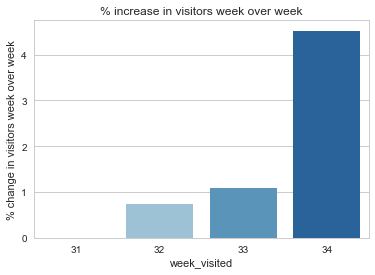

In [15]:
sns.barplot(x='week_visited',y='%_change_in_visitors',data=weekly_activity,palette='Blues')
plt.title('% increase in visitors week over week')
plt.ylabel('% change in visitors week over week');

In [16]:
# creating a flag checking if a day is a weekend or a weekday
visitors['is_weekend'] = np.where(pd.to_datetime(visitors.session_date).dt.weekday < 5, 0, 1)

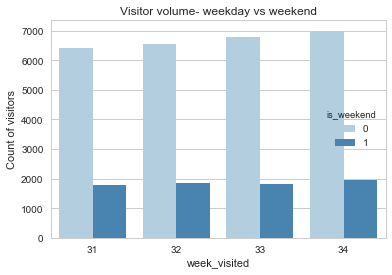

In [18]:
sns.barplot(x='week_visited',y='request_id',hue='is_weekend',data=visitors, estimator=len,palette='Blues')
plt.title('Visitor volume- weekday vs weekend')
plt.ylabel('Count of visitors');

There are fewer visits during the weekend overall all

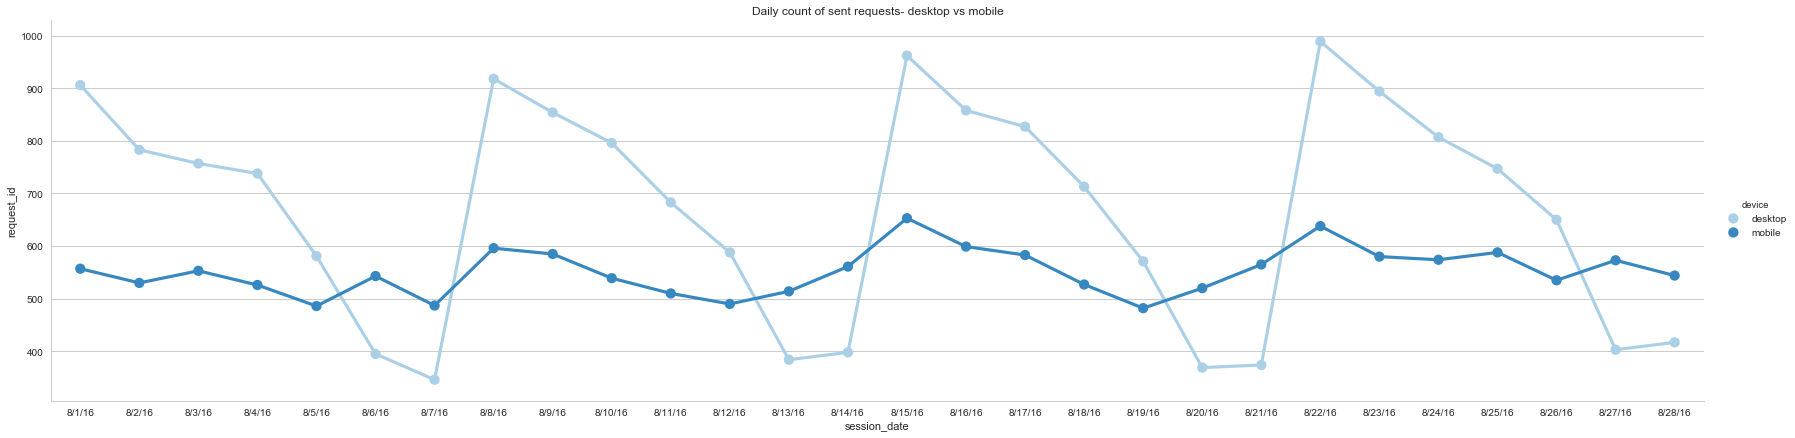

In [21]:
sns.factorplot(x='session_date',y='request_id',data=visitors,hue='device',ci=None,size=6,aspect=4,estimator=len,palette='Blues')
plt.title('Daily count of sent requests- desktop vs mobile');

In [22]:
# % of visitors submitting a project request
visitors.sent_request.sum()/len(visitors) * 100

56.9137942529502

In [23]:
#Percentage of sent requests per category
visitors.groupby('category_name')['sent_request'].sum() / visitors.sent_request.sum() * 100

category_name
House Cleaning (One Time)        32.115035
Local Moving (under 50 miles)    67.884965
Name: sent_request, dtype: float64

The largest contributors of sent requests are visitors from Local Moving (68%)

In [24]:
device_activity = visitors.groupby('device')['sent_request'].agg(['sum','size']).reset_index()
device_activity.columns = ['category_name','sent_requests','visits']
device_activity['conversion rate'] = device_activity['sent_requests'] / device_activity['visits'] * 100

In [25]:
device_activity

,category_name,sent_requests,visits,conversion rate
0,desktop,18708,32295,57.928472
1,mobile,15438,27701,55.730840


More than half the visitors access Thumbtack through desktop than Mobile, and the conversion rate for desktop is also better

In [26]:
category_activity = visitors.groupby('category_name')['sent_request'].agg(['sum','size']).reset_index()

category_activity.columns = ['category_name','sent_requests','visits']

category_activity['conversion rate'] = category_activity['sent_requests'] / category_activity['visits'] * 100

In [27]:
category_activity

,category_name,sent_requests,visits,conversion rate
0,House Cleaning (One Time),10966,17347,63.215542
1,Local Moving (under 50 miles),23180,42649,54.350630


Even though visitors send more Local Moving requests, the conversion rate for House Cleaning is better (63%)

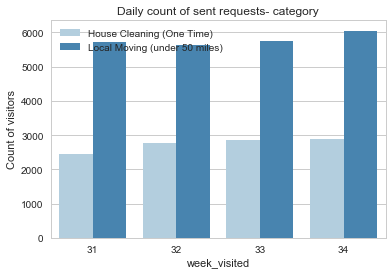

In [28]:
sns.barplot(x='week_visited',y='sent_request',hue='category_name',data=visitors,estimator=sum,palette='Blues',ci=None)
plt.title('Daily count of sent requests- category')
plt.ylabel('Count of visitors')
plt.legend(loc='upper left')

# Question 2

Quotes​ ​Per​ ​Request
* What is the distribution of number of quotes per request?
* What factors contribute to some requests getting more quotes than others?

In [29]:
#Extracting count of quotes for each request id from the quotes table
count_of_quotes = quotes.groupby('request_id')['quote_id'].count().reset_index()
count_of_quotes.columns = ['request_id','count_of_quotes']

In [30]:
count_of_quotes.count_of_quotes.value_counts()

2    7977
1    7630
3    6188
4    3139
5    1924
6       1
Name: count_of_quotes, dtype: int64

In [31]:
# finding out the % share of quote counts 
count_of_quotes.count_of_quotes.value_counts() / len(count_of_quotes) * 100

2    29.699542
1    28.407610
3    23.038832
4    11.686958
5     7.163334
6     0.003723
Name: count_of_quotes, dtype: float64

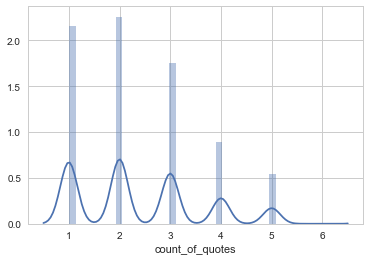

In [32]:
sns.distplot(count_of_quotes.count_of_quotes)

In [33]:
visitors_request_counts = visitors.merge(count_of_quotes, on='request_id',how='left')

In [34]:
# filling missing values with 0 to aid in analysis
visitors_request_counts.fillna(0, inplace=True)

#### Identifying requests that have more than 3 quotes to understand the drivers of have more quotes

In [35]:
more_than_3_quotes = visitors_request_counts.loc[visitors_request_counts.count_of_quotes > 3]

In [36]:
more_than_3_quotes.groupby('category_name')['request_id'].count()

category_name
House Cleaning (One Time)        1165
Local Moving (under 50 miles)    3899
Name: request_id, dtype: int64

In [38]:
more_than_3_quotes.groupby(['category_name','how_far'])['request_id'].count().reset_index()

,category_name,how_far,request_id
0,House Cleaning (One Time),0,1149
1,House Cleaning (One Time),11 - 20 miles,6
2,House Cleaning (One Time),21 - 30 miles,2
3,House Cleaning (One Time),31 - 50 miles,4
4,House Cleaning (One Time),5 - 10 miles,3
5,House Cleaning (One Time),Less than 5 miles,1
6,Local Moving (under 50 miles),0,38
7,Local Moving (under 50 miles),11 - 20 miles,938
8,Local Moving (under 50 miles),21 - 30 miles,635
9,Local Moving (under 50 miles),31 - 50 miles,539


In [39]:
more_than_3_quotes.groupby(['category_name','num_bedrooms'])['request_id'].count().reset_index()

,category_name,num_bedrooms,request_id
0,House Cleaning (One Time),0,26
1,House Cleaning (One Time),1 bedroom,101
2,House Cleaning (One Time),2 bedrooms,255
3,House Cleaning (One Time),3 bedrooms,462
4,House Cleaning (One Time),4 bedrooms,234
5,House Cleaning (One Time),5+ bedrooms,76
6,House Cleaning (One Time),Studio,11
7,Local Moving (under 50 miles),0,3884
8,Local Moving (under 50 miles),1 bedroom,2
9,Local Moving (under 50 miles),2 bedrooms,1


From the above tables, we observe that-

* Local Moving- a large number of requests for moves within 20 miles have 4 or 5 quotes
* House Cleaning- a large number of requests for cleaning are homes that have more than 2 bedrooms

#### Checking for each category what the drivers are

In [41]:
moving_data = visitors_request_counts.loc[visitors_request_counts.category_name== 'Local Moving (under 50 miles)']

In [42]:
more_than_3_moving = moving_data.loc[moving_data.count_of_quotes > 3]

In [43]:
more_than_3_moving.groupby('how_far')['request_id'].count().reset_index()

,how_far,request_id
0,0,38
1,11 - 20 miles,938
2,21 - 30 miles,635
3,31 - 50 miles,539
4,5 - 10 miles,753
5,Less than 5 miles,942
6,Within the same building,54


In [44]:
X_moving = moving_data[['device','how_far']]
y_moving = moving_data['count_of_quotes']
X_moving = pd.get_dummies(X_moving)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_moving, y_moving, test_size=0.20, random_state=42)

In [47]:
rf = RandomForestRegressor()

In [48]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [49]:
y_pred_moving = rf.predict(X_test)

In [50]:
mean_squared_error(y_test,y_pred_moving)

0.95301748611477599

In [51]:
sorted(list(zip(X_moving.columns,rf.feature_importances_)),key=lambda x: -1*x[1])

[('how_far_0', 0.95072616548946942),
 ('how_far_31 - 50 miles', 0.018732910718452459),
 ('how_far_21 - 30 miles', 0.018548009881173548),
 ('how_far_11 - 20 miles', 0.0098785180582103768),
 ('how_far_Within the same building', 0.0010005796026057931),
 ('device_desktop', 0.00059492378494537814),
 ('device_mobile', 0.00041516556617451412),
 ('how_far_Less than 5 miles', 5.3017986804070712e-05),
 ('how_far_5 - 10 miles', 5.0708912164537191e-05)]

In [53]:
cleaning_data = visitors_request_counts.loc[visitors_request_counts.category_name== 'House Cleaning (One Time)'].copy()

In [54]:
X_cleaning = cleaning_data[['device','num_bedrooms','num_bathrooms']]
y_cleaning = cleaning_data['count_of_quotes']
X_cleaning = pd.get_dummies(X_cleaning)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaning, y_cleaning, test_size=0.20, random_state=42)

In [56]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [57]:
y_pred_cleaning = rf.predict(X_test)
mean_squared_error(y_test,y_pred_cleaning)

0.87554832296309748

In [59]:
sorted(list(zip(X_cleaning.columns,rf.feature_importances_)),key=lambda x: -1*x[1])

[('num_bathrooms_0', 0.58644187863436315),
 ('num_bedrooms_0', 0.39191799753172579),
 ('num_bathrooms_1 bathroom', 0.0052091651500576017),
 ('device_mobile', 0.0019985507141861976),
 ('num_bedrooms_2 bedrooms', 0.0019629283629425303),
 ('num_bathrooms_1.5 bathrooms', 0.0018955486450180446),
 ('num_bedrooms_4 bedrooms', 0.0016371034995435862),
 ('num_bedrooms_5+ bedrooms', 0.0016265417018670725),
 ('device_desktop', 0.0012385824780104312),
 ('num_bedrooms_3 bedrooms', 0.0012030099751987938),
 ('num_bedrooms_1 bedroom', 0.001167143742079386),
 ('num_bedrooms_Studio', 0.0011084012704055488),
 ('num_bathrooms_3 bathrooms', 0.0010557235718064199),
 ('num_bathrooms_4+ bathrooms', 0.00084239479609903858),
 ('num_bathrooms_2 bathrooms', 0.00069502992669654231)]

In [402]:
more_than_3_cleaning = cleaning_data.loc[cleaning_data.count_of_quotes > 3]

In [419]:
more_than_3_cleaning.groupby('num_bedrooms')['request_id'].count().reset_index()

,num_bedrooms,request_id
0,0,26
1,1 bedroom,101
2,2 bedrooms,255
3,3 bedrooms,462
4,4 bedrooms,234
5,5+ bedrooms,76
6,Studio,11


In [60]:
def home_types(x):
    ''' A function to tag homes that have more than 2 bedrooms'''
    
    if x.num_bedrooms in ['3 bedrooms','4 bedrooms','5+ bedrooms']:
        return 'Homes with greater than 2 bedrooms'
    elif x.num_bedrooms == 0:
        return 'No bedroom count'
    else:
        return 'Homes with upto 2 bedrooms'

In [61]:
cleaning_data['home_type'] = cleaning_data.apply(lambda x: home_types(x),axis=1)

In [62]:
cleaning_data.groupby('home_type')['count_of_quotes'].mean().reset_index()

,home_type,count_of_quotes
0,Homes with greater than 2 bedrooms,2.068908
1,Homes with upto 2 bedrooms,1.882726
2,No bedroom count,0.038248


As noticed above, homes with more than 2 bedrooms have a greater average quote count than homes with fewer than 2 bedrooms

# Question 3

* By category, what is the distribution of quote prices for a project?
* By category, what price do you think Thumbtack should charge pros to quote? Why?
Explain your reasoning for any assumptions that you make.

In [63]:
# merging visitor and quotes data
overall_data = quotes.merge(visitors,on='request_id',how='left')

In [64]:
overall_data.groupby('category_name')['quote_price'].mean()

category_name
House Cleaning (One Time)        151.982718
Local Moving (under 50 miles)    350.821409
Name: quote_price, dtype: float64

In [65]:
overall_cleaning_data = overall_data.loc[overall_data.category_name == 'House Cleaning (One Time)']
overall_moving_data = overall_data.loc[overall_data.category_name == 'Local Moving (under 50 miles)']

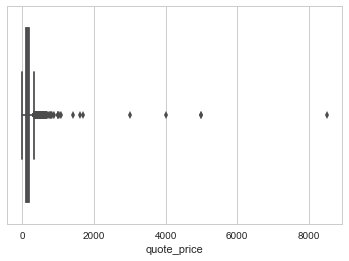

In [66]:
sns.boxplot(overall_cleaning_data.quote_price)

Since there are very few quotes above 800 dollars, we shall filter the quotes to below 800 dollars to obtain quote prices distributions

In [67]:
cleaning_quote_price = overall_cleaning_data.quote_price.loc[overall_cleaning_data.quote_price < 800]

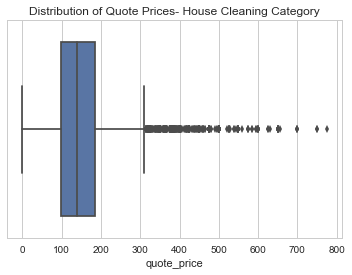

In [68]:
g = sns.boxplot(cleaning_quote_price)
plt.title('Distribution of Quote Prices- House Cleaning Category')

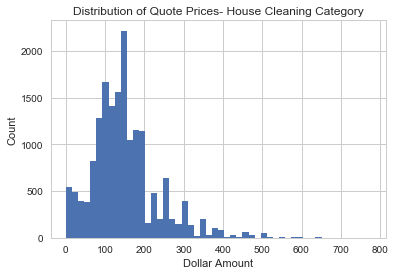

In [69]:
cleaning_quote_price.hist(bins=50)
plt.title('Distribution of Quote Prices- House Cleaning Category')
plt.xlabel('Dollar Amount')
plt.ylabel('Count')


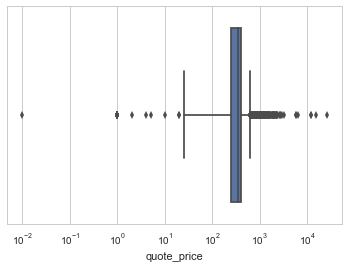

In [499]:
g = sns.boxplot(overall_moving_data.quote_price)
g.set_xscale('log')

In [70]:
moving_quote = overall_moving_data.quote_price.loc[overall_moving_data.quote_price < 800]

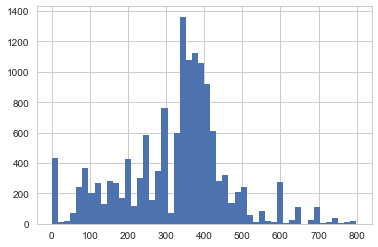

In [71]:
moving_quote.hist(bins=50)

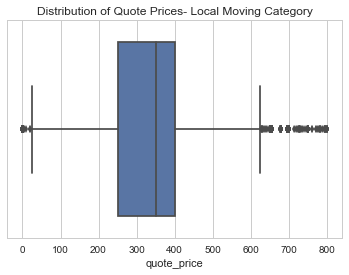

In [72]:
sns.boxplot(moving_quote)
plt.title('Distribution of Quote Prices- Local Moving Category')
plt.savefig('moving_price_dist.png',dpi=300,bbox_inches='tight')

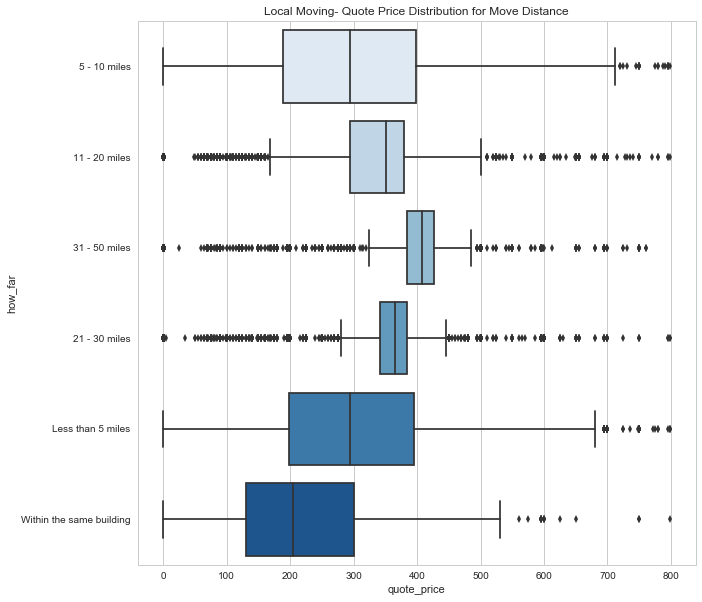

In [73]:
less_than_800_moving = overall_moving_data.loc[overall_moving_data.quote_price < 800]
plt.figure(figsize=(10,10))
g = sns.boxplot(x='quote_price',y='how_far',data=less_than_800_moving,palette='Blues')
plt.title('Local Moving- Quote Price Distribution for Move Distance')

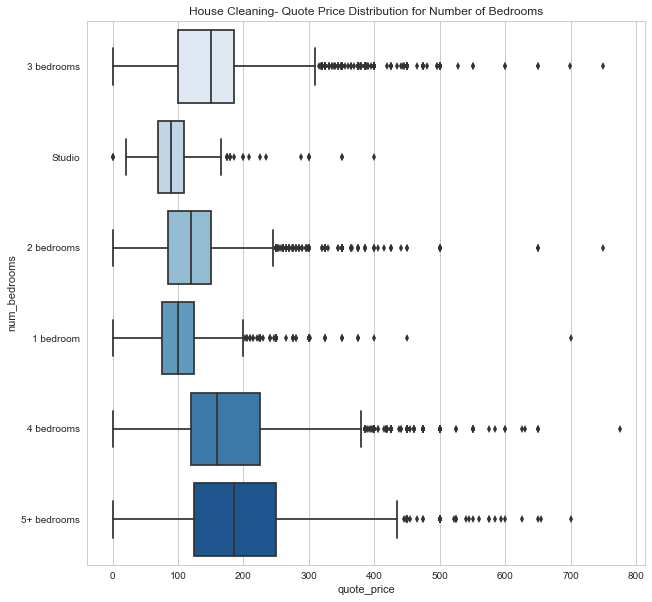

In [74]:
less_than_800_cleaning = overall_cleaning_data.loc[overall_cleaning_data.quote_price < 800]
plt.figure(figsize=(10,10))
g = sns.boxplot(x='quote_price',y='num_bedrooms',data=less_than_800_cleaning,palette='Blues')
plt.title('House Cleaning- Quote Price Distribution for Number of Bedrooms')

In [569]:
overall_data.groupby(['category_name','num_bedrooms'])['quote_price'].agg(['mean','median'])

mean  median
category_name                 num_bedrooms                    
House Cleaning (One Time)     1 bedroom     104.936083   100.0
                              2 bedrooms    129.694420   120.0
                              3 bedrooms    155.215701   150.0
                              4 bedrooms    179.951035   162.0
                              5+ bedrooms   205.888405   186.0
                              Studio        101.130453    90.0
Local Moving (under 50 miles) 1 bedroom     107.512821   100.0
                              2 bedrooms    137.029265   125.0
                              3 bedrooms    153.368049   150.0
                              4 bedrooms    165.452381   155.5
                              5+ bedrooms   211.666667   202.5
                              Studio         96.181818   100.0

In [76]:
# Cleaning quote prices that have the maximum occurence
overall_cleaning_data.quote_price.value_counts().head(5)

150.0    1427
100.0    1145
120.0     870
200.0     775
125.0     690
Name: quote_price, dtype: int64

In [77]:
# Moving quote prices that have the maximum occurence
overall_moving_data.quote_price.value_counts().head(5)

250.0    498
350.0    409
300.0    326
400.0    319
340.0    298
Name: quote_price, dtype: int64

#### For Local Moving

- A large volume of quote prices in the 250 - 400 range (250 and 350- most quoted price)
- As moving distance increases, the quote price ranges also increase
- < 5 miles and 5 - 10 miles price ranges are almost similar

#### For House Cleaning

- A large volume of quote prices in the 100 - 200 range (100 and 150 - most quoted price)
- Similar to Local Moving, the range of quote prices increase as the number of bedrooms increase
- Single Family Homes have higher quote price ranges


